### Upload the following folders from the simulator workbook if running on Google Colab
```
+--- inputs: 
|    +--- gtfs_line6_stops.csv
|    +--- gtfs_line6_stop_times.csv
|    +--- gtfs_line6_trips.csv
|    +--- beijing_line6_od.csv
+--- outputs: 
|    +--- train_outputs/*
|    +--- traveler_outputs/*
|    +--- beijing_line6_nodes.csv
|    +--- beijing_line6_links.csv
|    +--- beijing_line6_schedule.csv
```

### Viz 1: import modules

In [1]:
### computation
import numpy as np
import pandas as pd 
import datetime
import scipy.stats

### plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})

In [4]:
### set time limit
t_start = 3600*5
t_end = 3600*10

### scenario name
scen_nm = 'beijing_line6'

### input and output path
in_path = 'inputs' 
out_path = 'outputs' 

### Viz 2: show traveler traces.

In [5]:
### choose an OD to plot the trace
od_input = pd.read_csv('{}/{}_od.csv'.format(in_path, scen_nm))

### filter to only keep trips before the peak hours for this analysis
od_sample = od_input[(od_input['departure_time']>=3600*6) &
                     (od_input['departure_time']<3600*6.5) &
                     (od_input['exit_type']==1) &
                     (od_input['enter_station'] != od_input['exit_station'])].copy()
od_sample['traveler_id'] = od_sample.index
# od_sample

,traveler_id,traveler_status,association,update_time
2,57417,1,33.0,22080
3,57417,2,13.0,22180
4,57417,3,201033.0,22440
1,57417,1,18.0,23280
5,57417,4,41.0,23380


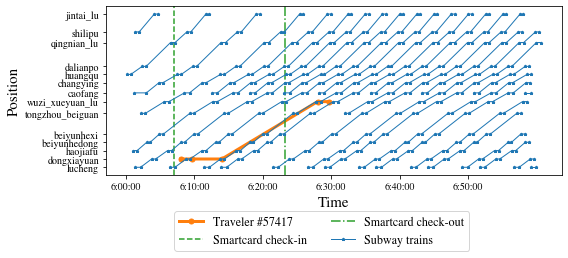

In [7]:
### get trace plot y axis
nodes = pd.read_csv('{}/{}_nodes.csv'.format(out_path, scen_nm))
nodes = nodes.sort_values(by='stop_lon', ascending=False)

nodes['x'] = nodes['geometry'].apply(lambda x: x.split('(')[1].split(' ')[0]).astype(float)
nodes['y'] = nodes['geometry'].apply(lambda x: x.split(')')[0].split(' ')[2]).astype(float)
stations_origin_x = float(nodes.iloc[0]['x'])
stations_origin_y = float(nodes.iloc[0]['y'])
nodes['distance'] = nodes.apply(lambda row: np.sqrt((row['x']-stations_origin_x)**2 + (row['y']-stations_origin_y)**2), axis=1)

fig, ax = plt.subplots(figsize=(8, 4))
stations = nodes[nodes['type']=='station'].copy()
ax.set_yticks(stations['distance'])
ax.set_yticklabels(stations['stop_id'])
ax.set_ylabel('Position', fontsize=15)
x_ticks = np.arange(3600*6, 3600*7, 600)
x_ticklabels = [str(datetime.timedelta(seconds=int(t))) for t in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels)
ax.set_xlabel('Time', fontsize=15)
    
### get trace plot of individual travelers
scen_nm_spec = scen_nm + '_cap1960-1960_tt90-90'
traveler_id = 57417
traveler_trace = pd.read_csv(
    '{}/traveler_outputs/traveler_trace_{}.csv'.format(out_path, scen_nm_spec))
traveler_trace = traveler_trace[traveler_trace['update_time']>0]
traveler_trace = traveler_trace[traveler_trace['traveler_id']==traveler_id]
traveler_trace = traveler_trace.sort_values(by='update_time', ascending=True)
display(traveler_trace)
traveler_trace['node_id'] = traveler_trace['association']
traveler_trace.loc[traveler_trace['traveler_status']==3, 'node_id'] = traveler_trace.loc[traveler_trace['traveler_status']==2, 'node_id'].values
traveler_trace = traveler_trace.merge(nodes[['node_id', 'distance']], how='left', on='node_id')
ax.plot(traveler_trace['update_time'], traveler_trace['distance'], '-o', lw=3, ms=5, c='C1', label='Traveler #{}'.format(traveler_id))

### check in time and arrival time for individual traveler
ftr = [3600,60,1]
checkin_time = od_sample.loc[traveler_id]['entry_time']
checkin_time = sum([a*b for a,b in zip(ftr, map(int,checkin_time.split(':')))])
ax.axvline(x=checkin_time, ls='--', c='C2', label='Smartcard check-in')
arrival_time = od_sample.loc[traveler_id]['deal_time']
arrival_time = sum([a*b for a,b in zip(ftr, map(int,arrival_time.split(':')))])
ax.axvline(x=arrival_time, ls='-.', c='C2', label='Smartcard check-out')

### get trace plot of the vehicles
schedule = pd.read_csv('{}/{}_schedule.csv'.format(out_path, scen_nm))
schedule = schedule[(schedule['time']>=3600*6) & (schedule['time']<=3600*7)]

i=0
for trip_id, grp in schedule.groupby('trip_id'):
    schedule_plot_list = []
    if grp.iloc[0]['location'].split('-')[0] != 'downward': continue
    for row in grp[grp['status']=='stop'].itertuples():
        schedule_plot_list.append([getattr(row, 'time'), getattr(row, 'location').split('-')[1]])
        schedule_plot_list.append([getattr(row, 'next_time'), getattr(row, 'location').split('-')[1]])
    schedule_plot_df = pd.DataFrame(schedule_plot_list, columns=['time', 'stop_id'])
    schedule_plot_df = pd.merge(schedule_plot_df, stations[['stop_id', 'distance']], how='left', on='stop_id')
    if i == 0:
        ax.plot(schedule_plot_df['time'], schedule_plot_df['distance'], '-*', lw=1, ms=3, c='C0', label='Subway trains')
    else:
        ax.plot(schedule_plot_df['time'], schedule_plot_df['distance'], '-*', lw=1, ms=3, c='C0')
    i += 1

plt.legend(loc=[0.15, -0.45], fontsize=12, ncol=2)
plt.tight_layout()
# plt.savefig('{}/figs/trace_plot_{}.png'.format(outpath, traveler_id), dpi=200)

### Viz 3: show service run traces.

,trip_id,time,next_time,status,location,location_id,time_diff
7219,501131,39627.0,39657.0,stop,downward-jintai_lu,26.0,6.083333
7652,521133,39992.0,40022.0,stop,downward-jintai_lu,26.0,6.083333


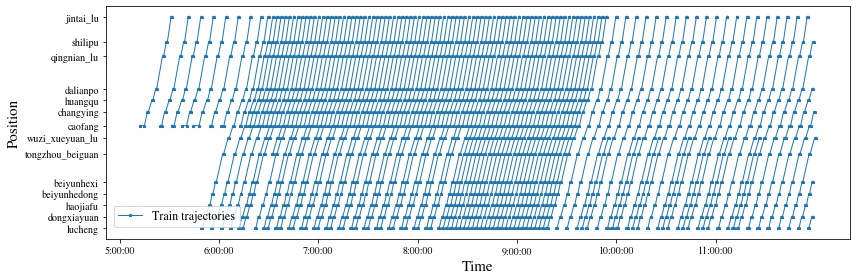

In [9]:
### get trace plot y axis
nodes = pd.read_csv('{}/{}_nodes.csv'.format(out_path, scen_nm))
nodes = nodes.sort_values(by='stop_lon', ascending=False)

nodes['x'] = nodes['geometry'].apply(lambda x: x.split('(')[1].split(' ')[0]).astype(float)
nodes['y'] = nodes['geometry'].apply(lambda x: x.split(')')[0].split(' ')[2]).astype(float)
stations_origin_x = float(nodes.iloc[0]['x'])
stations_origin_y = float(nodes.iloc[0]['y'])
nodes['distance'] = nodes.apply(lambda row: np.sqrt((row['x']-stations_origin_x)**2 + (row['y']-stations_origin_y)**2), axis=1)

fig, ax = plt.subplots(figsize=(12, 4))
stations = nodes[nodes['type']=='station'].copy()
ax.set_yticks(stations['distance'])
ax.set_yticklabels(stations['stop_id'])
ax.set_ylabel('Position', fontsize=15)
x_ticks = np.arange(3600*5, 3600*12, 3600)
x_ticklabels = [str(datetime.timedelta(seconds=int(t))) for t in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels)
ax.set_xlabel('Time', fontsize=15)

### get trace plot of the vehicles
schedule = pd.read_csv('{}/{}_schedule.csv'.format(out_path, scen_nm))
schedule = schedule[(schedule['time']>=3600*5) & (schedule['time']<=3600*12)]
tmp = schedule[schedule['location']=='downward-jintai_lu'].copy()
tmp = tmp.sort_values(by='next_time')
tmp['time_diff'] = (tmp['next_time'] - tmp['next_time'].shift())/60
display(tmp.iloc[100:102])

i=0
for trip_id, grp in schedule.groupby('trip_id'):
    schedule_plot_list = []
    if grp.iloc[0]['location'].split('-')[0] != 'downward': continue
    for row in grp[grp['status']=='stop'].itertuples():
        schedule_plot_list.append([getattr(row, 'time'), getattr(row, 'location').split('-')[1]])
        schedule_plot_list.append([getattr(row, 'next_time'), getattr(row, 'location').split('-')[1]])
    schedule_plot_df = pd.DataFrame(schedule_plot_list, columns=['time', 'stop_id'])
    schedule_plot_df = pd.merge(schedule_plot_df, stations[['stop_id', 'distance']], how='left', on='stop_id')
    if i == 0:
        ax.plot(schedule_plot_df['time'], schedule_plot_df['distance'], '-*', lw=1, ms=3, c='C0', label='Train trajectories')
    else:
        ax.plot(schedule_plot_df['time'], schedule_plot_df['distance'], '-*', lw=1, ms=3, c='C0')
    i += 1

plt.legend(loc=[0.01, 0.05], fontsize=12, ncol=2)
plt.tight_layout()
# plt.savefig('../uregina/figs/trace_plot_all_trains.png', dpi=200)

### Viz 4. Validation (capacity & walking time calibration)

In [11]:
### simulated and smartcard travel time
validation_dict = {
                    '{}_cap1960-1960_tt90-90'.format(scen_nm): None,
                  }

### read OD input
od_input = pd.read_csv('{}/{}_od.csv'.format(in_path, scen_nm))
od_input = od_input[od_input['enter_station'] != od_input['exit_station']].reset_index(drop=True)

### read simulated travel time output
for scen_nm_spec in validation_dict.keys():

    traveler_output = pd.read_csv(
        '{}/traveler_outputs/final_traveler_status_{}.csv'.format(out_path, scen_nm_spec))
    print(traveler_output.shape)

    od_input['deal_time'] = od_input['deal_time'].fillna('00:00:00')
    traveler_output['deal_time'] = pd.to_datetime(od_input['deal_time'])
    traveler_output['deal_time'] = (traveler_output['deal_time']-traveler_output['deal_time'].dt.normalize()
                                   ).dt.total_seconds().astype(int)
    traveler_output['exit_type'] = od_input['exit_type']
    traveler_output['enter_station'] = od_input['enter_station']
    traveler_output['exit_station'] = od_input['exit_station']
    
    validation_dict[scen_nm_spec] = traveler_output

(150725, 15)


In [12]:
### only those enter on Shahe Station
### and before 10.30

for scen_nm_spec in validation_dict.keys():
    traveler_output = validation_dict[scen_nm_spec]
    
    validation_set = traveler_output[
        (traveler_output['traveler_status']==4) & 
        (traveler_output['exit_type']==1) & 
        (traveler_output['deal_time']<=12*3600)].copy()

    validation_set['time_sim'] = validation_set['update_time']/3600 - validation_set['departure_time']/3600
    validation_set['time_card'] = validation_set['deal_time']/3600 - validation_set['departure_time']/3600
    validation_set['time_diff'] = - validation_set['update_time']/3600 + validation_set['deal_time']/3600
    
    ### validate without long smartcard travel time
    validation_set = validation_set[validation_set['time_card']<0.5]
    validation_set = validation_set[(validation_set['time_sim']>0) & (validation_set['time_sim']<1.5)]
    
    validation_dict[scen_nm_spec] = validation_set

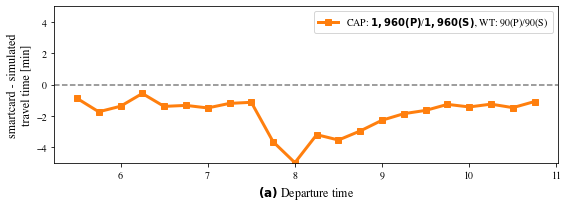

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.axhline(y=0, c='gray', ls='--')

validation_dict_1 = {
                   '{}_cap1960-1960_tt90-90'.format(scen_nm): ('C1', '-s', r'CAP: $\bf{1,960(P)}$/$\bf{1,960(S)}$, WT: 90(P)/90(S)')
                    }

def grp_statistics( g ):
    values = g['time_diff']
    mean = np.mean(values)
    std = np.std(values)
    rmse = np.sqrt(sum(values**2)/len(values))
    size = len(values)
    return pd.Series({'mean': mean, 'std': std, 'rmse': rmse, 'size': size})

for scen_nm_spec, scen_style in validation_dict_1.items():
    validation_set = validation_dict[scen_nm_spec]
    validation_set['departure_category'] = validation_set['departure_time']//900*0.25
    validation_grp = validation_set.groupby('departure_category').apply(grp_statistics).reset_index()
    validation_grp = validation_grp[(validation_grp['departure_category']>=5.5)]
    ax.plot(validation_grp['departure_category'].values, 
                   validation_grp['mean'].values*60, 
                   scen_style[1], c=scen_style[0],
                   lw=3, label=scen_style[2])
    ax.set_ylim([-5, 5])
    ax.set_xlabel(r'$\bf{(a)}$ Departure time', fontsize=12)
    ax.set_ylabel('smartcard - simulated\ntravel time [min]', fontsize=12)
    ax.legend(loc=1)

plt.tight_layout()
# plt.savefig('{}/{}_tune_cap_tt.png'.format(out_path, scen_nm), dpi=300)

### Viz 5: show platform crowdness.

In [19]:
platform_crowdness_dict = {
                           '{}_cap1960-1960_tt90-90'.format(scen_nm): None,
                          }

platform_crowdness = []
for scen_nm_spec in platform_crowdness_dict.keys():
    for t in range(t_start, 3600*12, 20):
        traveler_locations = pd.read_csv(
            '{}/traveler_outputs/agg_traveler_outputs_{}_{}.csv'.format(out_path, scen_nm_spec, t))
        traveler_locations['time'] = t
        traveler_locations['scen_nm'] = scen_nm_spec
        ### traveler status 2 is "platform"
        platform_crowdness += traveler_locations[traveler_locations['traveler_status']==2].values.tolist()

platform_crowdness = pd.DataFrame(platform_crowdness,
                                  columns=['traveler_status', 'platform_name', 'num_travelers', 'time', 'scen_nm'])

##### Viz 5.1 Individual platform: arrival passengers, aboard passengers

Text(0, 0.5, 'Platform crowdness (# travelers)')

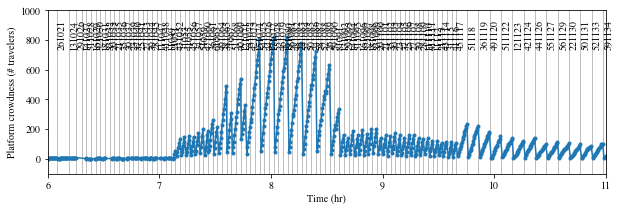

In [24]:
### retrieve platform data
# platform_nm, platform_nm_text = (16, 'downward-beiyunhexi')
# platform_nm, platform_nm_text = (0, 'downward-caofang')
platform_nm, platform_nm_text = (1, 'downward-changying')

### plotting
fig, ax = plt.subplots(figsize=(10, 3))

### retrieve schedule data
schedule = pd.read_csv('{}/{}_schedule.csv'.format(out_path, scen_nm))
single_platform_schedule = schedule[(schedule['location']==platform_nm_text) & (schedule['status']=='stop')].copy()

single_platform_schedule = single_platform_schedule.sort_values(by='time', ascending=True)
single_platform_schedule['interval'] = np.round((single_platform_schedule['time'].shift(-1) - single_platform_schedule['time'])/60, 1)
single_platform_schedule['hour'] = single_platform_schedule['time']/3600


### add train_id
for row in single_platform_schedule.itertuples():
    ax.axvline(getattr(row, 'time')/3600, -100, 600, lw=0.5, c='gray')
    ax.annotate(getattr(row, 'trip_id'), (getattr(row, 'time')/3600+0.005, 750), rotation=90, fontsize=10, c='black')
    # ax.annotate(getattr(row, 'interval'), (getattr(row, 'time')/3600-0.03, 300), rotation=90, fontsize=10, c='b')
ax.axvline(7, 0, 0, lw=0.5, c='gray', label='Train arrival')

for scen_nm_spec in platform_crowdness_dict.keys():
    single_platform = platform_crowdness[(platform_crowdness['platform_name']==platform_nm) & (
        platform_crowdness['scen_nm']==scen_nm_spec)].copy()
    # display(single_platform[(single_platform['time']>8*3600-100) & (single_platform['time']<8.1*3600)])
    ### add platform crowdness
    ax.plot(single_platform['time']/3600, single_platform['num_travelers'], '.-', c='C0', label='Platform crowdness')
    single_platform['hour'] = single_platform['time']/3600
    # display(single_platform[(single_platform['hour']>=7.6) & (single_platform['hour']<=7.7)])  

ax.set_xlim([6, 11])
ax.set_ylim([-100, 1000])
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Platform crowdness (# travelers)')
# fig.legend(ncol=1, bbox_to_anchor=(0.35, 0.2), loc='center left', title='Platform {}'.format(platform_nm_text.split('-')[1]), fontsize=10)
# plt.title('Train arrival and # passengers on platform {}'.format(platform_nm_text))
# plt.tight_layout()
# plt.savefig('{}/platform_crowdness_{}_zoom.png'.format(out_path, platform_nm_text), dpi=300)

### Viz 6. train occupancy

In [27]:
# train_occupancy_dict = {'changping_interv0': None, 'changping_interv1': None}
train_occupancy_dict = {'{}_cap1960-1960_tt90-90'.format(scen_nm): None
                       }
for scen_nm in train_occupancy_dict.keys():

    train_occupancy = []
    for t in range(t_start, 3600*11, 20):
        traveler_locations = pd.read_csv(
            '{}/traveler_outputs/agg_traveler_outputs_{}_{}.csv'.format(out_path, scen_nm, t))
        traveler_locations['time'] = t
        traveler_locations = traveler_locations[traveler_locations['traveler_status']==3]
        traveler_locations['trip_id'] = traveler_locations['association'].astype(int)

        train_positions = pd.read_csv('{}/train_outputs/train_outputs_{}_{}.csv'.format(out_path, scen_nm, t))
        train_positions['train_status'] = train_positions['status']
        # if t>=38700:
        #     print(t)
        #     display(train_positions[train_positions['trip_id']==trip_id])
        traveler_locations = traveler_locations.merge(
            train_positions[['trip_id', 'train_status', 'location']],
            how='right', on='trip_id')
        traveler_locations['time'] = t
        train_occupancy += traveler_locations[['traveler_status', 'trip_id', 'num_travelers',
                                              'time', 'train_status', 'location']].values.tolist()
        # if t>=30000:
        #     print(t)
        #     tmp = traveler_locations[traveler_locations['trip_id']==trip_id]
        #     print(tmp.shape)

    train_occupancy = pd.DataFrame(train_occupancy, 
                                   columns=['traveler_status', 'trip_id', 'num_travelers', 'time', 
                                            'train_status', 'location'])
    train_occupancy_dict[scen_nm] = train_occupancy

##### 6.1 Individual train occupancy

Text(0.5, 1.0, 'Platforms and # passengers on train 441076')

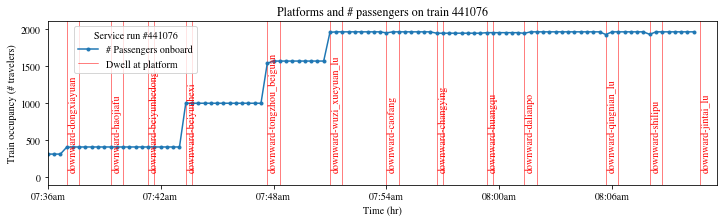

In [28]:
### retrieve individual train data
trip_id = 441076 #551078, 171077

### plotting
fig, ax = plt.subplots(figsize=(12, 3))

### add train occupancy
label_dict={'line_6_validation_cap1960-1960_tt90-90': 'Before', 'changping_line_validation_0528_cap1800': 'After'}
for scen_nm, train_occupancy in train_occupancy_dict.items():
    single_train = train_occupancy[train_occupancy['trip_id']==trip_id]
    # display(single_train.tail())
    ### add platform name
    for row in single_train.groupby(['train_status', 'location']).agg(
        {'time': 'first'}).reset_index().itertuples():
        ax.axvline(getattr(row, 'time')/3600, -100, 600, lw=0.5, c='r')
        if getattr(row, 'train_status') == 'on_link': continue
        ax.annotate(getattr(row, 'location'), (getattr(row, 'time')/3600+0.001, 100), rotation=90, fontsize=10, c='r')
    ax.plot(single_train['time']/3600, single_train['num_travelers'], '.-', label='# Passengers onboard')
ax.axvline(7, 0, 0, lw=0.5, c='r', label='Dwell at platform')

ax.set_xlim([7.6, np.max(single_train['time'])/3600+0.01])
fmt = lambda t, pos: '{:02}:{:02}am'.format(int(float(t)*3600//3600), int((float(t)*3600%3600)//60))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
ax.set_ylim([-100, 2100])
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Train occupancy (# travelers)')
lgd = fig.legend(ncol=1, bbox_to_anchor=(0.15, 0.75), loc='center left', title='Service run #{}'.format(trip_id), fontsize=10)
plt.title('Platforms and # passengers on train {}'.format(trip_id))
# plt.savefig('../uregina/figs/train_occupancy_tripid_{}_before.png'.format(trip_id), dpi=200,
#            bbox_extra_artists=(lgd,), bbox_inches='tight')